# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import os
import multiprocessing as mp
import itertools as it
import numpy as np
import pandas as pd

from scipy.signal import butter, lfilter, sosfilt, iirnotch, filtfilt
from scipy import ndimage

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from ECGXMLReader import ECGXMLReader
from preprocess import preprocess

# Globals

In [11]:
DATA_BASE_PATH = "/mnt/cluster_vsbud-dl1-005/hackathon"
META_PATH = "/mnt/cluster_vsbud-dl1-005/hackathon_meta/metadata.csv"

In [15]:
df_meta = pd.read_csv(META_PATH, sep=',', index_col=0)  

df_meta['EntryDate'] = pd.to_datetime(df_meta['EntryDate'])
df_meta['EntryTime'] = pd.to_datetime(df_meta['EntryTime'])
df_meta['EndDate'] = pd.to_datetime(df_meta['EndDate'])
df_meta['EndTime'] = pd.to_datetime(df_meta['EndTime'])

len(df_meta)

33523

In [16]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33523 entries, 0 to 33522
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   VentricularRate       33523 non-null  int64         
 1   AtrialRate            33523 non-null  int64         
 2   PRInterval            22292 non-null  float64       
 3   QRSDuration           33523 non-null  int64         
 4   QTInterval            33523 non-null  int64         
 5   QTCorrected           33523 non-null  int64         
 6   PAxis                 22020 non-null  float64       
 7   RAxis                 33523 non-null  int64         
 8   TAxis                 33523 non-null  int64         
 9   QRSCount              33523 non-null  int64         
 10  QOnset                33523 non-null  int64         
 11  QOffset               33523 non-null  int64         
 12  POnset                22166 non-null  float64       
 13  POffset         

In [17]:
df_meta.describe().T

,count,mean,std,min,25%,50%,75%,max
VentricularRate,33523.0,84.900964,26.488829,22.0,67.0,79.0,97.0,246.0
AtrialRate,33523.0,97.613101,62.308859,0.0,66.0,79.0,101.0,681.0
PRInterval,22292.0,176.448861,439.816281,40.0,146.0,166.0,192.0,65532.0
QRSDuration,33523.0,104.134594,27.154937,4.0,86.0,96.0,112.0,414.0
QTInterval,33523.0,394.876354,60.415846,82.0,358.0,394.0,428.0,776.0
QTCorrected,33523.0,455.770217,49.309208,0.0,425.0,449.0,479.0,917.0
PAxis,22020.0,52.970481,33.921842,-89.0,37.0,54.0,69.0,270.0
RAxis,33523.0,17.014975,56.985846,-89.0,-22.0,12.0,49.0,270.0
TAxis,33523.0,52.634579,64.585517,-89.0,14.0,43.0,80.0,270.0
QRSCount,33523.0,13.952510,4.374476,4.0,11.0,13.0,16.0,40.0


# Preprocess

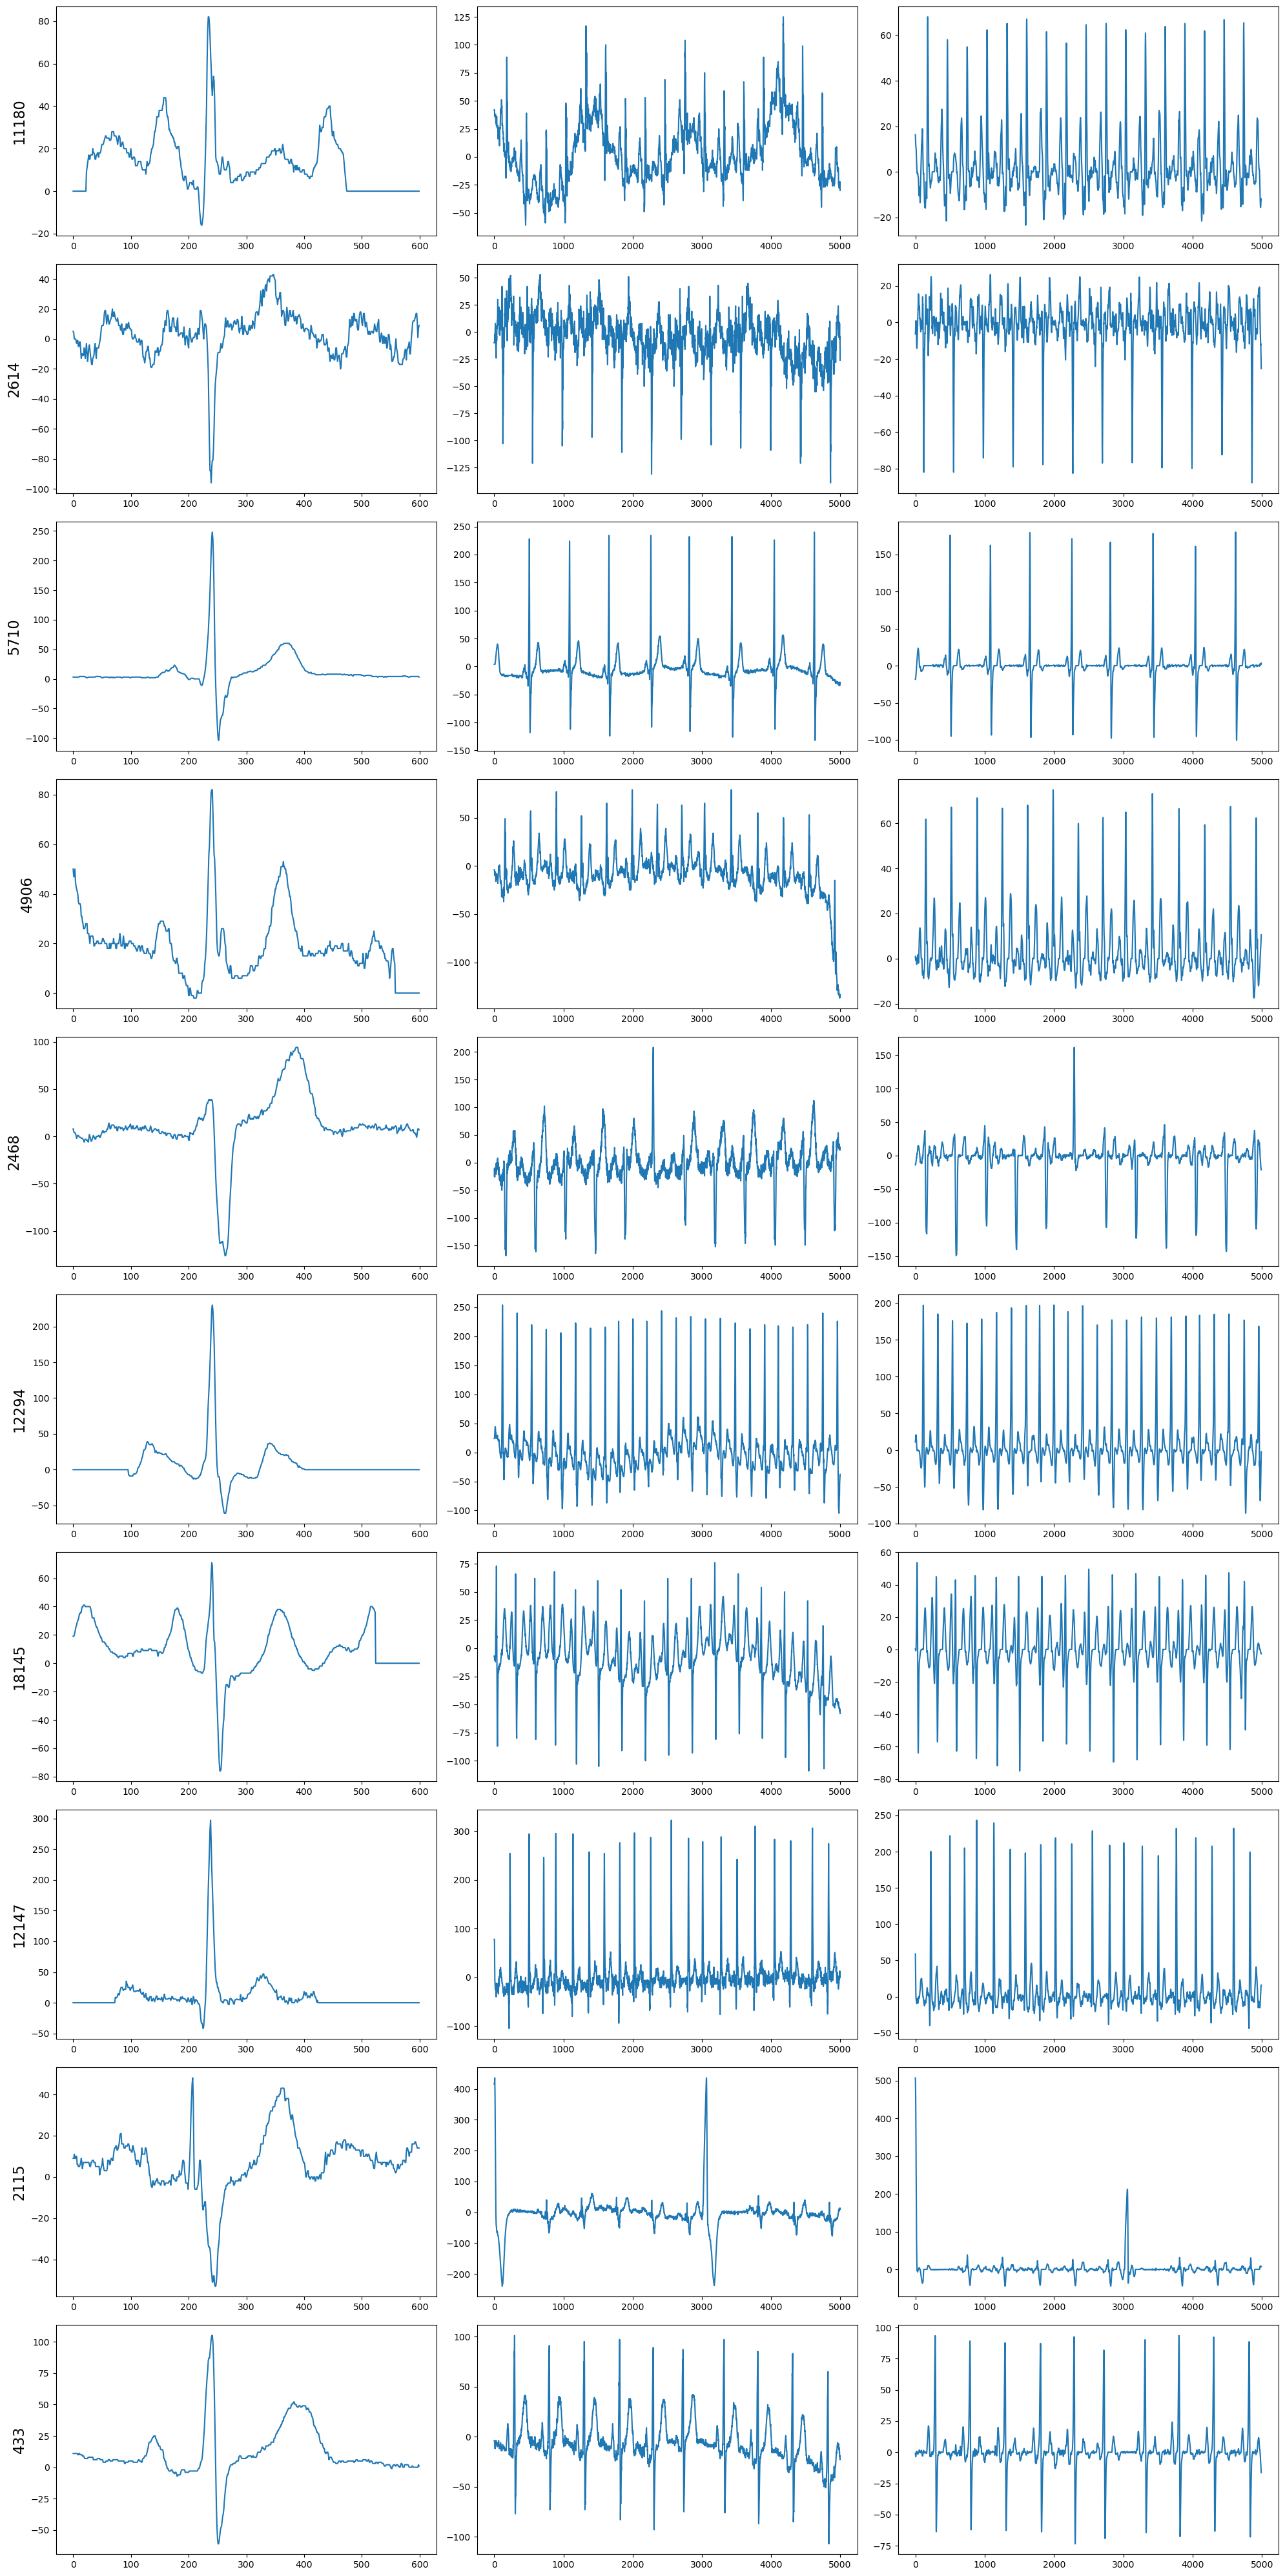

In [18]:
nrow = 10
fig, axs = plt.subplots(nrow, 3, figsize=(20, nrow*4))

# for i, fname in enumerate(df_meta[df_meta['DischargeTo_Agg'] == 'other']['file'].values[:nrow]):
for i, fname in enumerate(df_meta['file'].values[:nrow]):
    ecg = ECGXMLReader(f'{DATA_BASE_PATH}/{fname}', augmentLeads=True)
    
    ax = axs[i, 0]
    ax.plot(ecg.LeadVoltages[0]['II'])
    ax.set_ylabel(ecg.PatientDemographics['PatientID'], fontsize=16)
    
    ax = axs[i, 1]
    ax.plot(ecg.LeadVoltages[1]['II'])
    
    ax = axs[i, 2]
    ax.plot(preprocess(ecg.LeadVoltages[1]['II']))
    
fig.tight_layout()
plt.show()

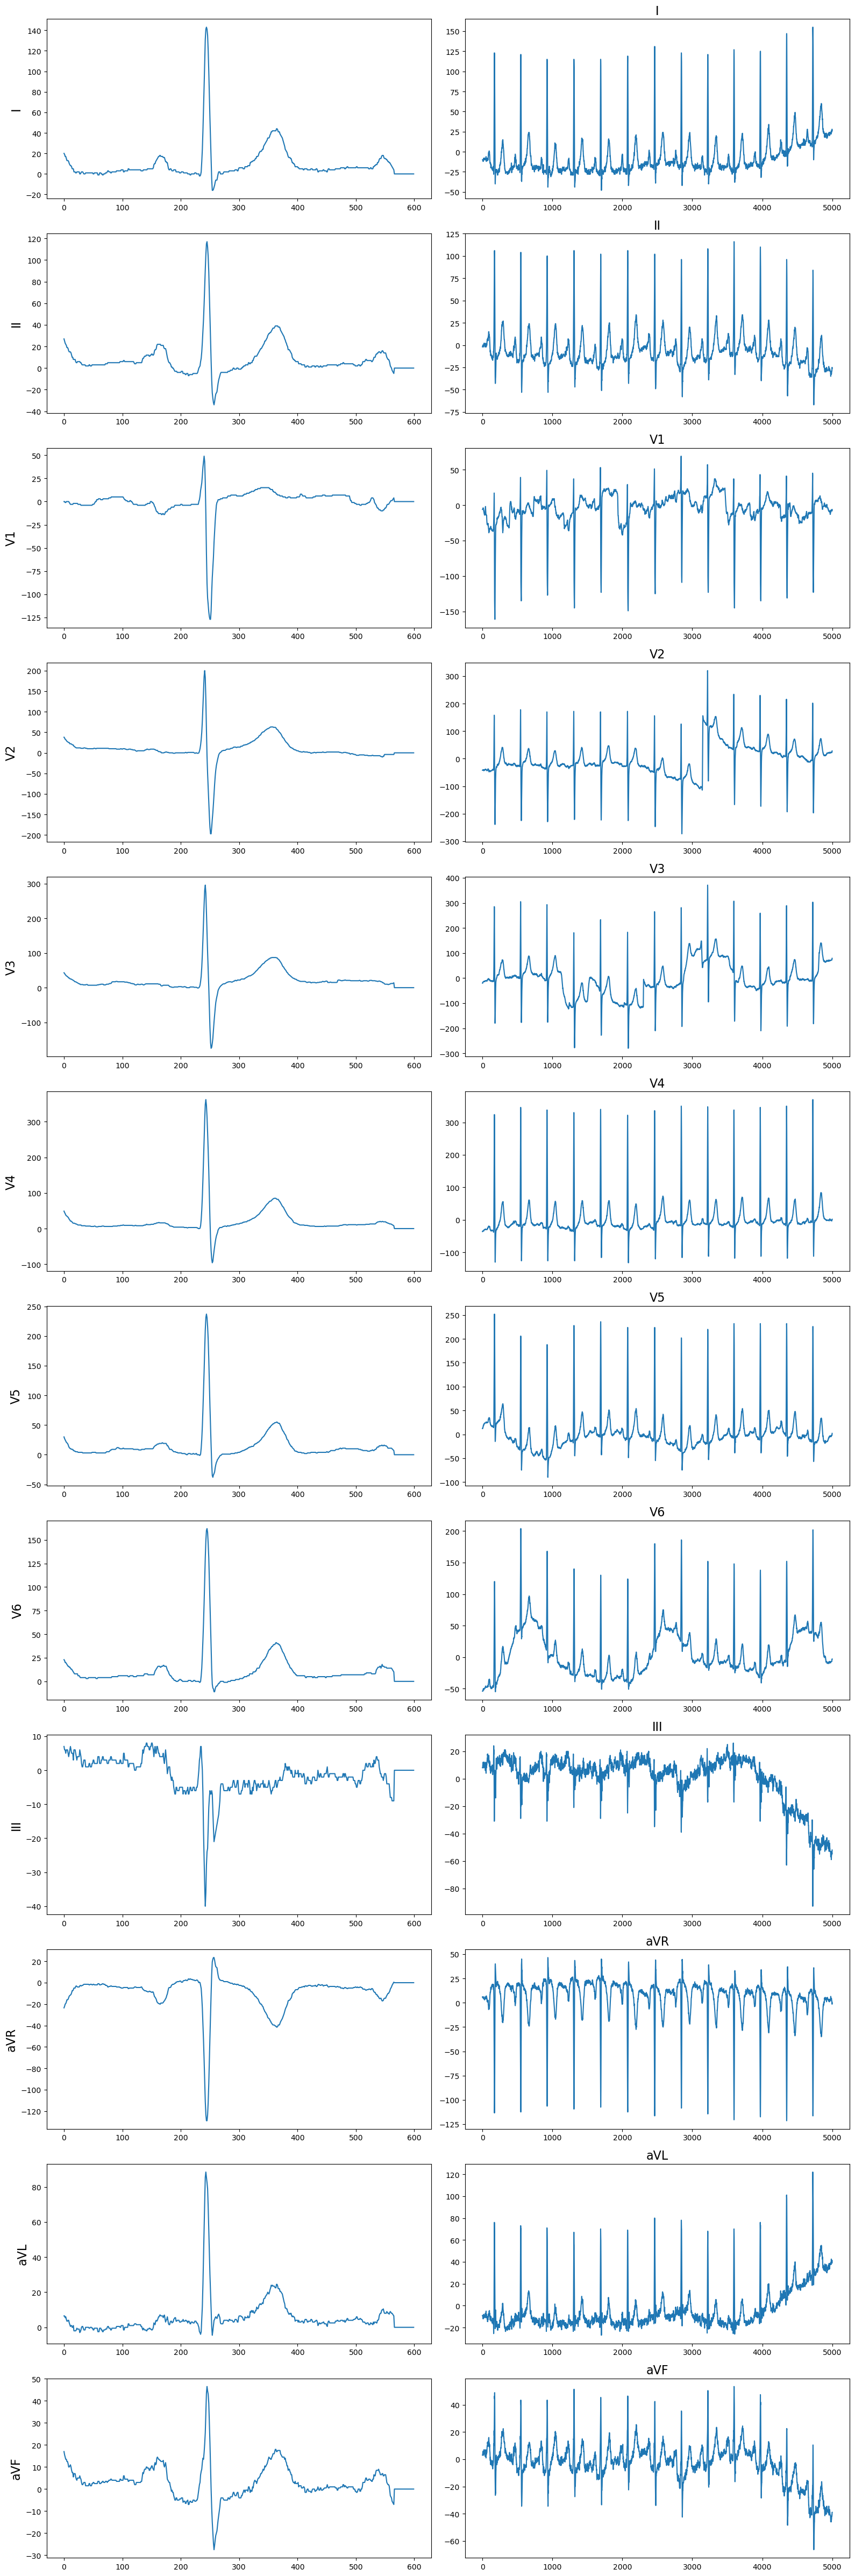

In [ ]:
ecg = ECGXMLReader(f'{DATA_BASE_PATH}/{df_meta["file"][10]}', augmentLeads=True)

nrow = len(ecg.LeadVoltages[0])
fig, axs = plt.subplots(nrow, 2, figsize=(16, nrow*4))

for i, (key, voltages) in enumerate(ecg.LeadVoltages[0].items()):
    
    ax = axs[i, 0]
    
    ax.plot(voltages)
    ax.set_ylabel(key, fontsize=16)
    
for i, (key, voltages) in enumerate(ecg.LeadVoltages[1].items()):
    
    ax = axs[i, 1]
    
    ax.plot(voltages)
    ax.set_title(key, fontsize=16)
    
fig.tight_layout()
plt.show()

# Feature engineering

## Relative R peak matrix

In [98]:
def get_channel_r_values(ecg, window=2):
    
    lead_voltages = ecg.LeadVoltages[0]
    loc = np.argmax(lead_voltages['I'])
    
    r_values = {}
    for key, voltages in lead_voltages.items():
        r_values[key] = np.mean(voltages[loc-window:loc+window])
        
    return r_values

def get_r_ratio_mtx(r_values):
    mtx = np.zeros((len(r_values), len(r_values)))
    for (i1, v1), (i2, v2) in it.combinations(enumerate(r_values.values()), 2):
        mtx[i1, i2] = v1 / v2
        mtx[i2, i1] = v2 / v1
    return mtx

dict_values([60.25, 24.5, -62.25, -96.75, -138.0, -4.75, 112.0, 122.75, -35.75, -42.375, 48.0, -5.625])


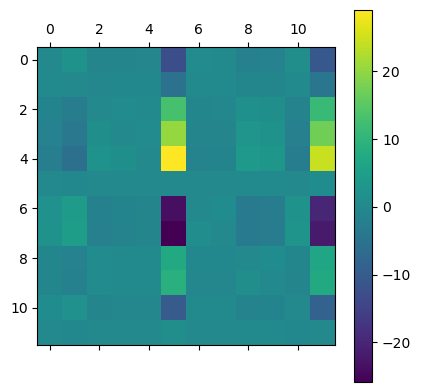

In [99]:
ecg = ECGXMLReader(f"{DATA_BASE_PATH}/{df_meta['file'].values[70]}", augmentLeads=True)
r_values = get_channel_r_values(ecg)

print(r_values.values())
plt.matshow(get_r_ratio_mtx(r_values))
plt.colorbar()

In [117]:
is_valid.shape

(33523,)

In [ ]:
def calc_r_vector(fname):
    ecg = ECGXMLReader(f"{DATA_BASE_PATH}/{fname}", augmentLeads=True)
    r_values = get_channel_r_values(ecg)
    r_ratio_mtx = get_r_ratio_mtx(r_values)
    return r_ratio_mtx.ravel()

pool = mp.Pool(40)
r_ratio_vectors = pool.map(calc_r_vector, df_meta['file'].values)

# filter too shoret vector (god knows why this happened)
r_ratio_vectors = np.array(r_ratio_vectors)
is_valid = np.array(list(map(len, r_ratio_vectors))) == 144
r_ratio_vectors = np.stack(r_ratio_vectors[is_valid])

# filter inf elements (divbide by zero)
is_number = (np.isinf(r_ratio_vectors).any(1) == False) & (np.isnan(r_ratio_vectors).any(1) == False)
r_ratio_vectors = r_ratio_vectors[is_number]

r_ratio_vectors.shape

In [120]:
from sklearn.decomposition import PCA
from umap import UMAP

pca = PCA(n_components=0.95)
umap = UMAP(n_components=2, n_neighbors=500)

r_vec_reduced = pca.fit_transform(r_ratio_vectors)
r_vec_reduced.shape

(33238, 24)